# Ultimate Challenge

## Part 1 - Exploratory Data Analysis

In [1]:
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from graphviz import Digraph
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.dates as dates
from matplotlib.dates import DateFormatter
import matplotlib.dates as mdates
from matplotlib.dates import MO, TU, WE, TH, FR, SA, SU
from datetime import date

In [2]:
logins = pd.read_json('logins.json')

In [3]:
logins.head()

,login_time
0,1970-01-01 20:13:18
1,1970-01-01 20:16:10
2,1970-01-01 20:16:37
3,1970-01-01 20:16:36
4,1970-01-01 20:26:21


In [4]:
logins.dtypes

login_time    datetime64[ns]
dtype: object

In [5]:
logins.index = logins.login_time

In [6]:
logins.head()

,login_time
login_time,
1970-01-01 20:13:18,1970-01-01 20:13:18
1970-01-01 20:16:10,1970-01-01 20:16:10
1970-01-01 20:16:37,1970-01-01 20:16:37
1970-01-01 20:16:36,1970-01-01 20:16:36
1970-01-01 20:26:21,1970-01-01 20:26:21


In [7]:
logins_15min = logins.resample('15min').count().rename(columns={'login_time':'login_count'})
logins_15min.head()

,login_count
login_time,
1970-01-01 20:00:00,2
1970-01-01 20:15:00,6
1970-01-01 20:30:00,9
1970-01-01 20:45:00,7
1970-01-01 21:00:00,1


In [10]:
logins_15min.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 9788 entries, 1970-01-01 20:00:00 to 1970-04-13 18:45:00
Freq: 15T
Data columns (total 1 columns):
 #   Column       Non-Null Count  Dtype
---  ------       --------------  -----
 0   login_count  9788 non-null   int64
dtypes: int64(1)
memory usage: 152.9 KB


<Figure size 432x288 with 0 Axes>

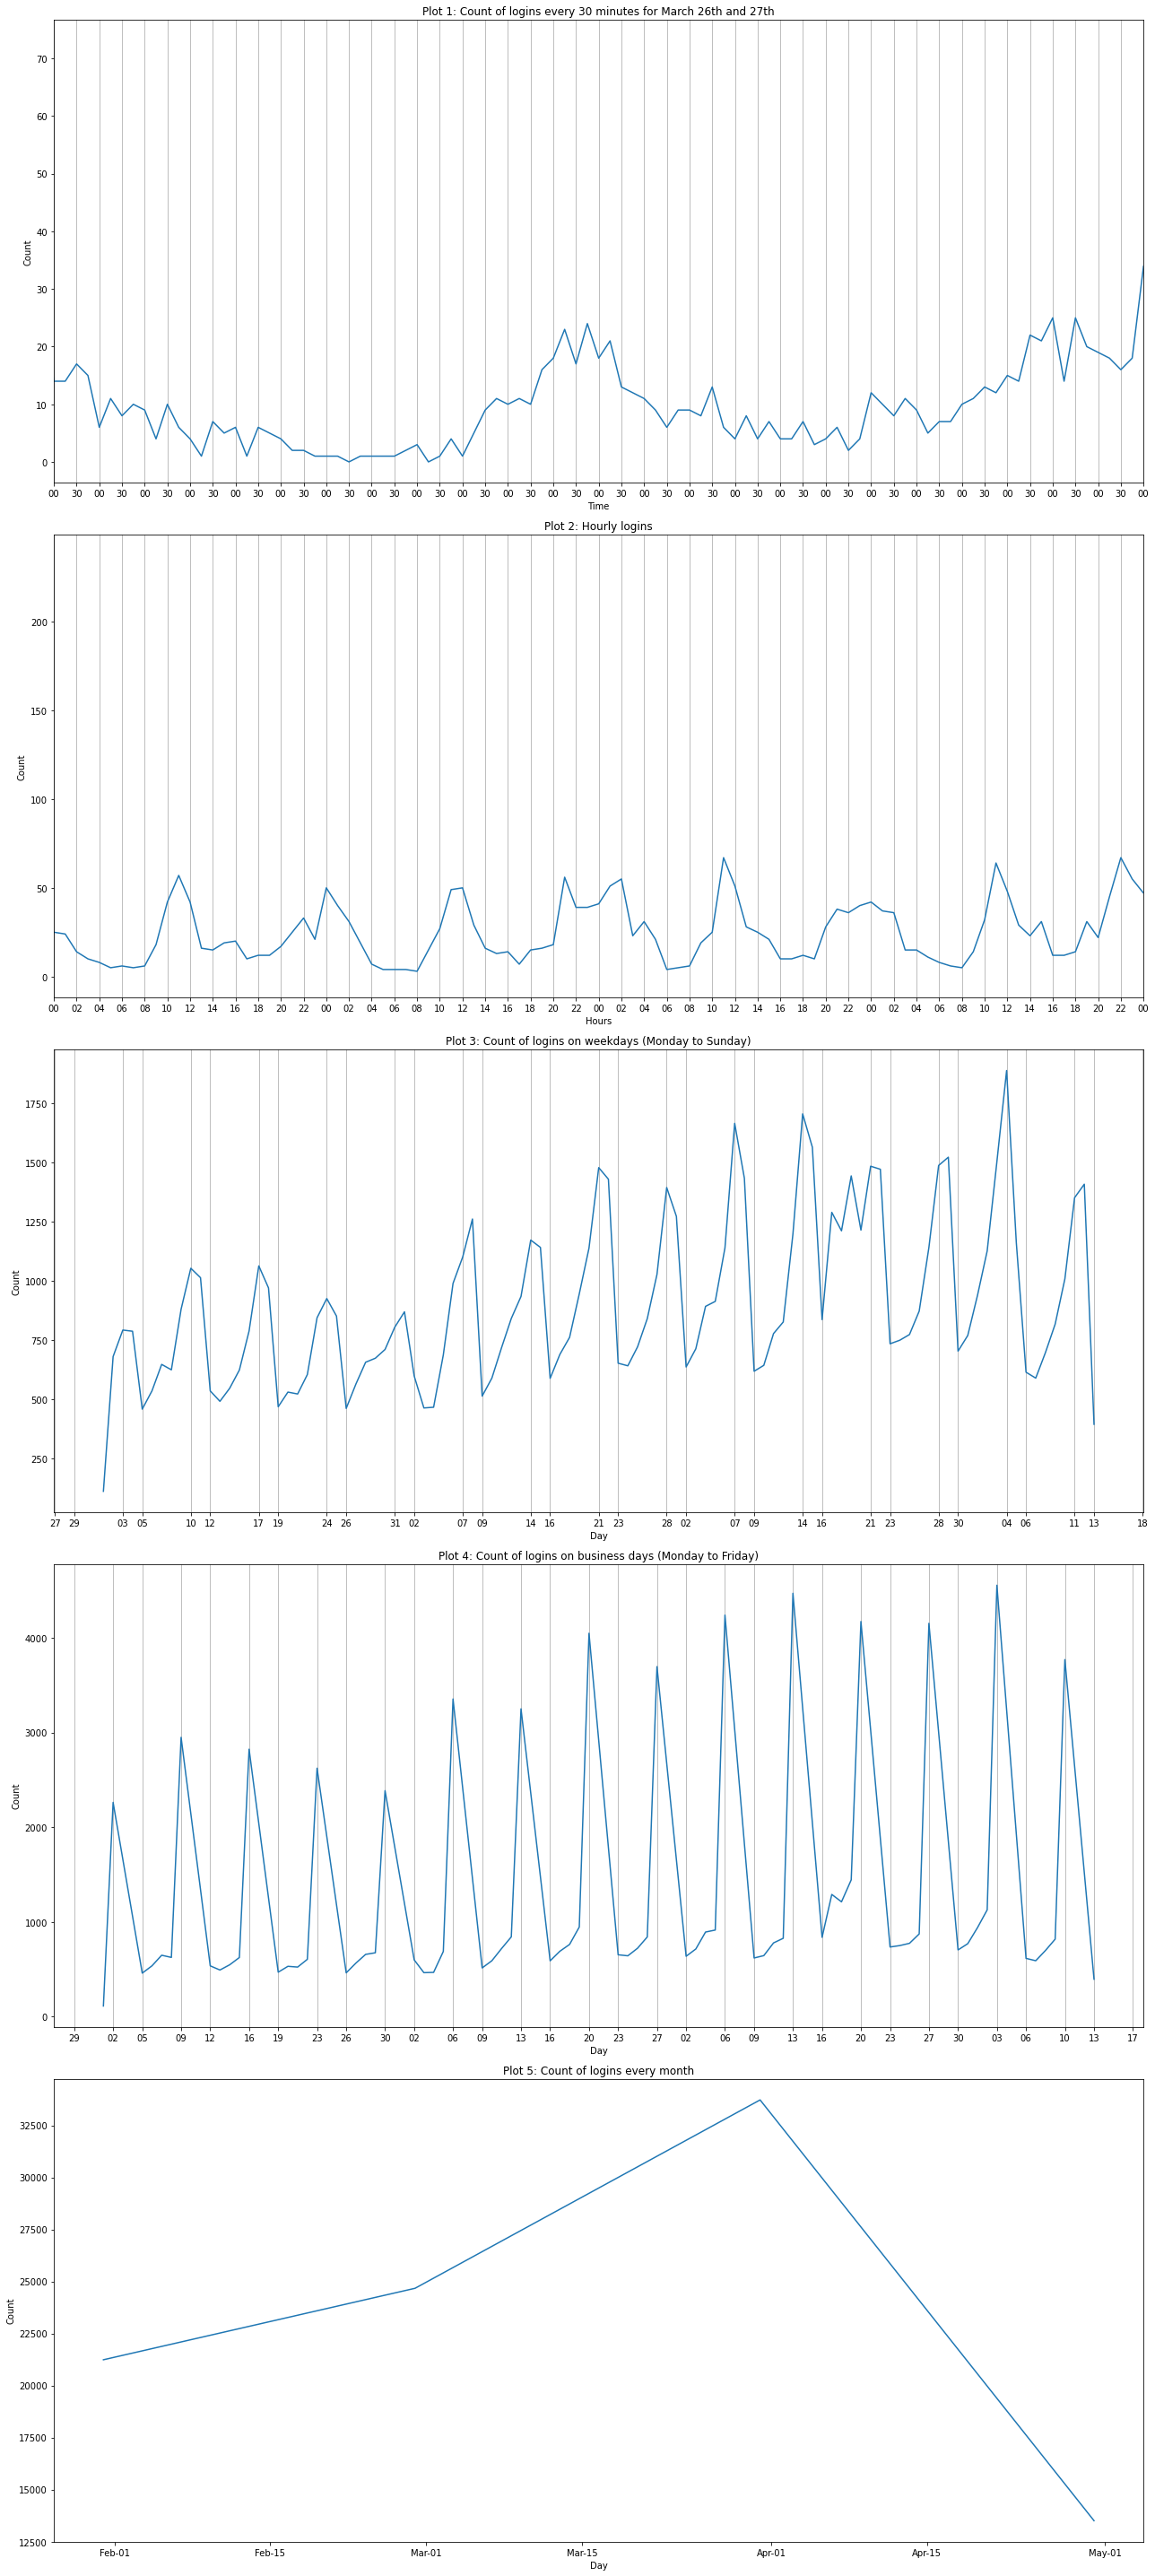

In [11]:
#Plot charts of login counts over different time intervals
plt.clf()
fig, ax = plt.subplots(5, 1, figsize = (18,40))
date_form_min = DateFormatter("%M")
ax[0].plot(logins_15min.index, logins_15min.login_count)
ax[0].set_title('Plot 1: Count of logins every 30 minutes for March 26th and 27th')
ax[0].set_xlabel('Time')
ax[0].set_ylabel('Count')
ax[0].grid(axis = 'x')
ax[0].set_xlim([date(1970, 3, 26), date(1970, 3, 27)])
ax[0].xaxis.set_major_formatter(date_form_min)
ax[0].xaxis.set_major_locator(mdates.MinuteLocator(interval = 30))

date_form_hr = DateFormatter("%H")
logins_hrly = logins.resample('H').count().rename(columns={'login_time':'login_count'})
ax[1].plot(logins_hrly.index, logins_hrly.login_count)
ax[1].set_title('Plot 2: Hourly logins')
ax[1].set_xlabel('Hours')
ax[1].set_ylabel('Count')
ax[1].grid(axis = 'x')
ax[1].set_xlim([date(1970, 1, 26), date(1970, 1, 30)])
ax[1].xaxis.set_major_formatter(date_form_hr)
ax[1].xaxis.set_major_locator(mdates.HourLocator(interval = 2))


logins_daily = logins.resample('D').count().rename(columns={'login_time':'login_count'})
date_from_weekdays = DateFormatter("%d")
ax[2].plot(logins_daily.index, logins_daily.login_count)
ax[2].set_title('Plot 3: Count of logins on weekdays (Monday to Sunday)')
ax[2].set_xlabel('Day')
ax[2].set_ylabel('Count')
ax[2].xaxis.set_major_formatter(date_from_weekdays)
ax[2].xaxis.set_major_locator(mdates.WeekdayLocator(byweekday= [MO, SA]))
ax[2].grid(axis = 'x')

logins_weekday = logins.resample('B').count().rename(columns={'login_time':'login_count'})
ax[3].plot(logins_weekday.index, logins_weekday.login_count)
ax[3].set_title('Plot 4: Count of logins on business days (Monday to Friday)')
ax[3].set_xlabel('Day')
ax[3].set_ylabel('Count')
ax[3].xaxis.set_major_formatter(date_from_weekdays)
ax[3].xaxis.set_major_locator(mdates.WeekdayLocator(byweekday= [MO, FR]))
ax[3].grid(axis = 'x')


date_form_month = DateFormatter("%b-%d")
logins_monthly = logins.resample('M').count().rename(columns={'login_time':'login_count'})
ax[4].plot(logins_monthly.index, logins_monthly.login_count)
ax[4].set_title('Plot 5: Count of logins every month')
ax[4].set_xlabel('Day')
ax[4].set_ylabel('Count')
ax[4].xaxis.set_major_formatter(date_form_month)


plt.tight_layout()
plt.show();


We make the following observations from the plots above:
- We examined a 2 day span (plot 1) and observed no discernable trend over 15 minute intervals.
- We examined a 3 day span (plot 2) and observed that there are two peak periods during the day - at lunch between 10 and 12 pm, and in the evening between 9 pm and 2 am. 
- For plot 3, we note that during weekdays Mondays typically have the lowest logins while Fridays have the highest logins
- For plot 4 (when we consider the entire week) Mondays still have the lowest logins while Saturdays have the highest logins
- For plot 5 we note that demand rises from January to March (at its peak) before drastically falling in april.

## Part 2 - Experiment and Metrics Design

Given a situation where drivers from Gotham and Metropolis tend to offer rides in their respective cities despite opportunities to offer rides in each other's city due to complementary active hours, we need to determine how a toll reimbursement incentive plan can encourage drivers.

The question we seek to answer is the following:
Will toll reimbursement cause drivers from city A to offer rides in city B?

### Choice of Metric

To answer the question above, we need to first of all determine a relevant metric to assess if the incentive plan works. <br>The base metric we have chosen is - __the number of rides per week completed by a driver from city A in city B__.
 - We chose the _number of rides_ measure because it captures completed rides, suggesting the conclusion of a transaction between the driver and rider.
 - We chose the _per working week_ measure because it covers the base working day cycle that includes the most active hours for city A and city B, and the variation associated with different days of the week.
 - We chose the _number of rides completed by a driver from city A in city B_ because it targets the constraints associated with toll costs that repel drivers from offering rides in the neighboring city.

### Experimental Design

We recommend that managers run five weekly experiments over the span of three months to test the effectiveness of the toll-reimbursement incentive plan. The weekly experiments will assess uptake of incentive offers over weekdays. 

Each city manager will design an experiment that has the following foundational steps:
1. Gather data on drivers and their transactions. The driver records must include a unique identifier for each driver. Transaction records must include location information and transaction dates.
2. Determine frequency and recency thresholds to determine the activity level of drivers. For our experiment, we recommend a threshold frequency of twice per week and a recency threshold of 1 week. 
3. Randomly select a sample of 1000 drivers that satisfy the pre-determined frequency and recency thresholds.
4. Randomly provide toll-reimbursement offers to half of the drivers to encourage them to provide service in the neigbhoring city. 
5. Track metrics for each group:
    a. Record the number of rides completed by each driver in the neighboring city for each day of the work week.

### Analyze the Data

1. For each group
    a. Sum the number of rides completed by each driver for the work week.
    b. Find the mean number of rides completed drivers
2. For both groups
    a. Find the difference in means between the mean obtained from the group given the incentive and the group not given the incentive.

#### State the Null Hypothesis

Ho: The difference in means between the group that received the toll-reimbursement offer and the group that did not receive the offer is not due to toll-reimbursement.
<br>H1: The difference in means is due to toll-reimbursement


#### Conduct the t-test

We define the level of signifance with a p-value of 0.05. We will reject the null-hypothesis if the p-value is less than or equal to 0.05.

### Recommendation

As noted, the experiment should be conducted 5 times over the span of a 3-month period to increase our confidence in our values. If all experiments yield significant p-values, we will conclude that the toll-reimbursement plan likely encouraged the drivers to offer rides in the neighboring city. We will therefore recommend that the managers implement the toll-reimursement scheme to all drivers.

# Part 3 - Retention Prediction

## Data Wrangling

Our goal is to explore the factors that determine if a rider is retained, and to furthermore predict which riders are likely to churn.

In [12]:
riders = pd.read_json('ultimate_data_challenge.json')

In [13]:
riders.head()

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver
0,King's Landing,4,2014-01-25,4.7,1.10,2014-06-17,iPhone,15.4,True,46.2,3.67,5.0
1,Astapor,0,2014-01-29,5.0,1.00,2014-05-05,Android,0.0,False,50.0,8.26,5.0
2,Astapor,3,2014-01-06,4.3,1.00,2014-01-07,iPhone,0.0,False,100.0,0.77,5.0
3,King's Landing,9,2014-01-10,4.6,1.14,2014-06-29,iPhone,20.0,True,80.0,2.36,4.9
4,Winterfell,14,2014-01-27,4.4,1.19,2014-03-15,Android,11.8,False,82.4,3.13,4.9


In [14]:
riders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   city                    50000 non-null  object 
 1   trips_in_first_30_days  50000 non-null  int64  
 2   signup_date             50000 non-null  object 
 3   avg_rating_of_driver    41878 non-null  float64
 4   avg_surge               50000 non-null  float64
 5   last_trip_date          50000 non-null  object 
 6   phone                   49604 non-null  object 
 7   surge_pct               50000 non-null  float64
 8   ultimate_black_user     50000 non-null  bool   
 9   weekday_pct             50000 non-null  float64
 10  avg_dist                50000 non-null  float64
 11  avg_rating_by_driver    49799 non-null  float64
dtypes: bool(1), float64(6), int64(1), object(4)
memory usage: 4.2+ MB


In [15]:
#Convert date features to datetime format
riders.signup_date = pd.to_datetime(riders.signup_date)
riders.last_trip_date = pd.to_datetime(riders.last_trip_date)

In [16]:
#Create function to determine if a user is active or inactive. A user is inactive if the last_trip_date exceeds 30 days
latest_trip = riders.last_trip_date.max()

def user_status(date):
    delta = (latest_trip - date).days
    if delta < 30:
        status = 'active'
    else:
        status = 'inactive'        
    return status

In [17]:
#Create a feature that shows the status of a user
riders['status'] = riders.last_trip_date.apply(user_status)
riders.status.head()

0      active
1    inactive
2    inactive
3      active
4    inactive
Name: status, dtype: object

In [18]:
riders.head()

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver,status
0,King's Landing,4,2014-01-25,4.7,1.10,2014-06-17,iPhone,15.4,True,46.2,3.67,5.0,active
1,Astapor,0,2014-01-29,5.0,1.00,2014-05-05,Android,0.0,False,50.0,8.26,5.0,inactive
2,Astapor,3,2014-01-06,4.3,1.00,2014-01-07,iPhone,0.0,False,100.0,0.77,5.0,inactive
3,King's Landing,9,2014-01-10,4.6,1.14,2014-06-29,iPhone,20.0,True,80.0,2.36,4.9,active
4,Winterfell,14,2014-01-27,4.4,1.19,2014-03-15,Android,11.8,False,82.4,3.13,4.9,inactive


In [19]:
#Create profile report to review dataframe
from pandas_profiling import ProfileReport
profile = ProfileReport(riders, title="Pandas Profiling Report")

In [20]:
#profile

From the pandas profiling report:
- We have to deal with the missing values in avg_rating_of_driver feature 

### Reviewing Numerical Features

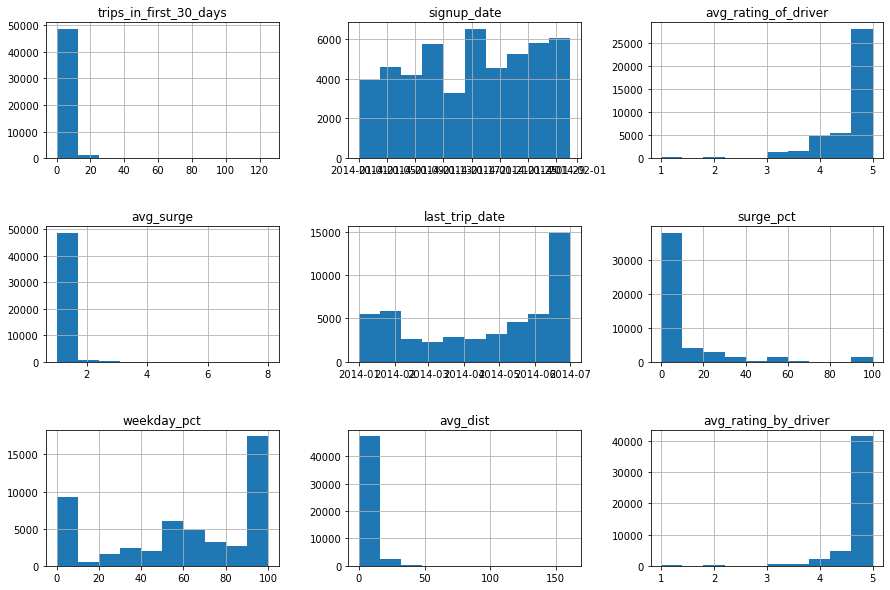

In [21]:
riders.hist(figsize = (15, 10));
plt.subplots_adjust(hspace= 0.5);

Trips in first 30 days and avg_surge seem to be highly skewed. Let's review these features in more details.

#### Trips in first 30 days

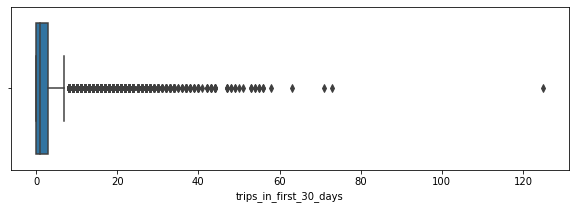

In [22]:
#Create boxplot of trips_in_first_30_days to see the extent of outliers
plt.figure(figsize = (10,3))
sns.boxplot(data = riders, x = 'trips_in_first_30_days');

It appears that there are a few riders that took over 20 trips within the first 30 days. Let us view the summary satistics of this feature.

In [23]:
riders.trips_in_first_30_days.describe()

count    50000.000000
mean         2.278200
std          3.792684
min          0.000000
25%          0.000000
50%          1.000000
75%          3.000000
max        125.000000
Name: trips_in_first_30_days, dtype: float64

We observe the max number of trips taken by a rider within 30 days is 120. This implies that an indivual took 4 trips a day. This seems a bit excessive. We will view this sample and decide whether to remove it from the dataset.

In [24]:
riders[riders.trips_in_first_30_days > 120]

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver,status
18514,King's Landing,125,2014-01-02,5.0,1.12,2014-06-30,iPhone,14.4,True,72.0,2.02,4.8,active


We note that this individual takes a high percentage of his trips on weekdays (72%) and has a high surge percentage (14.4%). It is therefore possible that this individual uses the service to commute on a daily basis. This individual may be an executive that moves between offices. We will keep this sample.

#### Average Surge

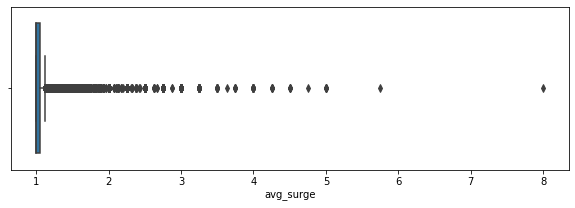

In [25]:
#Create boxplot of avg_surge to see the extent of outliers
plt.figure(figsize = (10,3))
sns.boxplot(data = riders, x = 'avg_surge');

In [26]:
#View samples with avg_surge values greater than 3
riders[riders.avg_surge > 4].head()

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver,status
1405,Winterfell,1,2014-01-08,5.0,4.75,2014-01-21,iPhone,100.0,False,100.0,6.46,5.0,inactive
2817,Winterfell,0,2014-01-02,5.0,5.00,2014-02-05,iPhone,100.0,False,100.0,3.18,5.0,inactive
5355,Winterfell,1,2014-01-10,5.0,4.25,2014-01-11,Android,100.0,False,100.0,0.69,5.0,inactive
10546,Winterfell,0,2014-01-03,NaN,4.50,2014-06-21,iPhone,100.0,False,0.0,2.70,5.0,active
13861,Winterfell,1,2014-01-01,1.0,8.00,2014-01-01,iPhone,100.0,False,100.0,5.77,5.0,inactive


It is difficult to establish a pattern associated with these high avg_surge values. We will retain these samples in the dataframe. 

### Reviewing Categorical Features

In [27]:
riders.select_dtypes('object').columns

Index(['city', 'phone', 'status'], dtype='object')

#### City

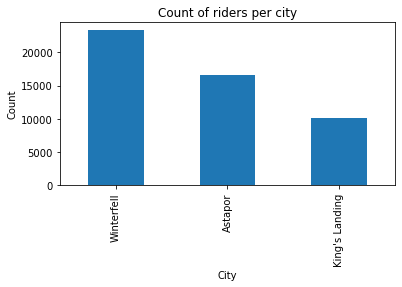

In [28]:
#Plot count of cities
plt.figure(figsize = (6,3))
riders.city.value_counts().plot.bar()
plt.title('Count of riders per city')
plt.xlabel('City')
plt.ylabel('Count');

We observe that most of the riders are located in Winterfell and least of them in King's Landing

#### Phone

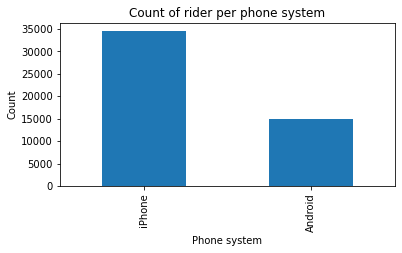

In [29]:
#Plot count of cities
plt.figure(figsize = (6,3))
riders.phone.value_counts().plot.bar()
plt.title('Count of rider per phone system')
plt.xlabel('Phone system')
plt.ylabel('Count');

We note here that most of the riders use iPhones.

#### Status

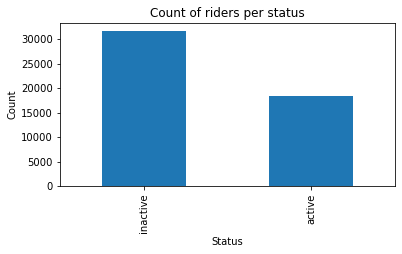

In [30]:
#Plot count of cities
plt.figure(figsize = (6,3))
riders.status.value_counts().plot.bar()
plt.title('Count of riders per status')
plt.xlabel('Status')
plt.ylabel('Count');

We observe that there are more riders that are inactive than active.

In [31]:
#Compute ratio of active to inactive riders
riders.status.value_counts()[0] / riders.status.value_counts()[1]

1.7307482250136537

We observe a ratio of 1.73 inactive riders for every active driver. 

## Exploratory Data Analysis

In [32]:
numerical_features = riders.select_dtypes(['int64', 'float64']).columns.to_list()

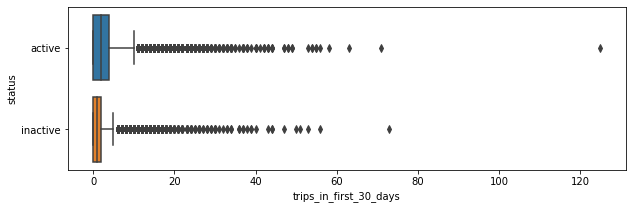

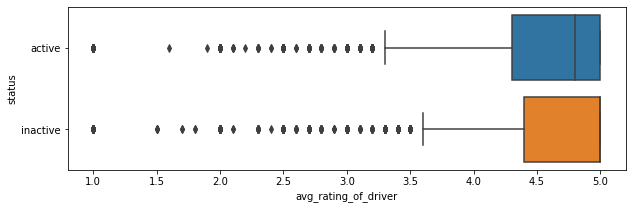

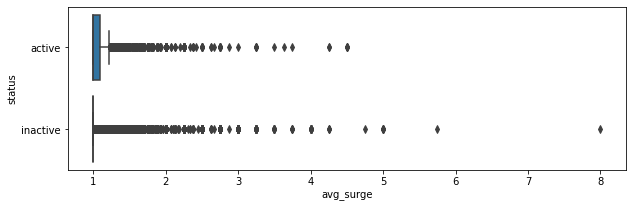

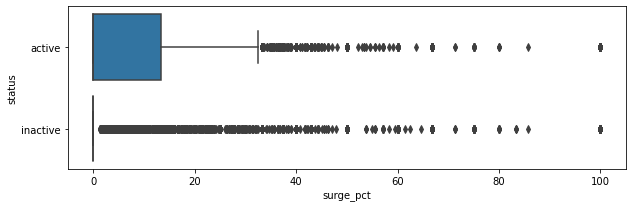

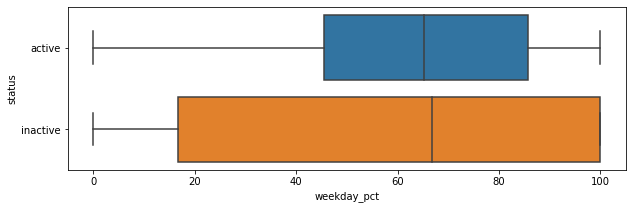

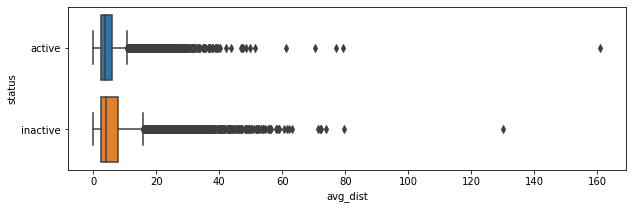

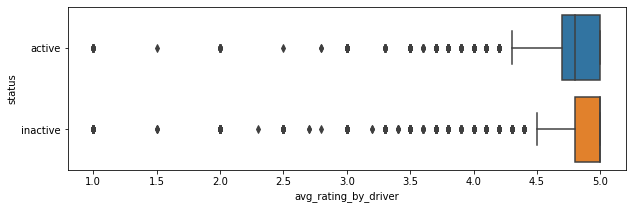

In [33]:
for feature in numerical_features:
    plt.figure(figsize = (10, 3))
    sns.boxplot(data = riders, x = f'{feature}', y = 'status')

We note that the box plot for active riders is shifted to the right compared to inactive riders suggesting that riders that make more trips within the first 30 days are likely to be active. Futhermore, surge pricing are not expose to surge pricing. Hence surge pricing is likely to be an indicator of status.

In [34]:
#Review correlation matrix of dataset
riders.status = riders.status.replace({'active': 1, 'inactive': 0})

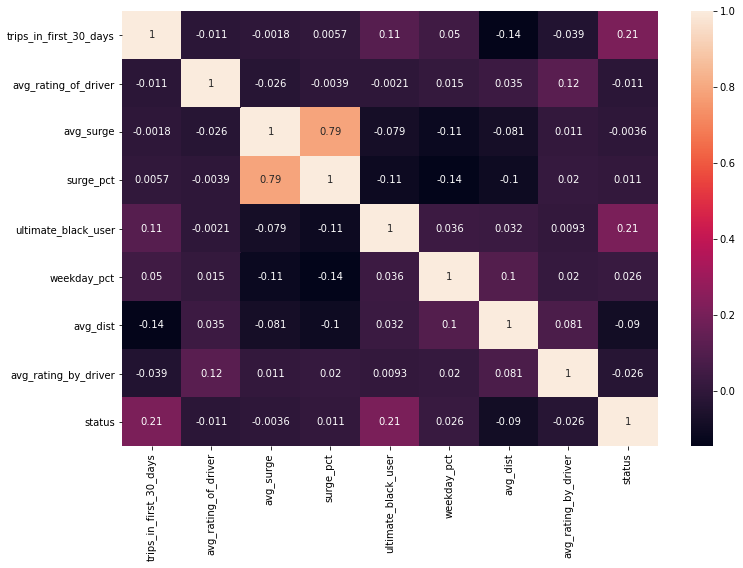

In [35]:
plt.figure(figsize = (12, 8))
sns.heatmap(riders.corr(), annot = True);

We notice here that avg_surge and surge_pct are highly correlated with each other, suggesting the presence of some redundancy. We will consider droppping one of these features for our model.

## Pre-processing

In [36]:
riders.head()

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver,status
0,King's Landing,4,2014-01-25,4.7,1.10,2014-06-17,iPhone,15.4,True,46.2,3.67,5.0,1
1,Astapor,0,2014-01-29,5.0,1.00,2014-05-05,Android,0.0,False,50.0,8.26,5.0,0
2,Astapor,3,2014-01-06,4.3,1.00,2014-01-07,iPhone,0.0,False,100.0,0.77,5.0,0
3,King's Landing,9,2014-01-10,4.6,1.14,2014-06-29,iPhone,20.0,True,80.0,2.36,4.9,1
4,Winterfell,14,2014-01-27,4.4,1.19,2014-03-15,Android,11.8,False,82.4,3.13,4.9,0


### Feature Engineering

In [37]:
#Create new features for the dates 
riders['signup_month'] = riders.signup_date.dt.month
riders['signup_day'] = riders.signup_date.dt.day
riders['last_trip_month'] = riders.last_trip_date.dt.month
riders['last_trip_day'] = riders.last_trip_date.dt.day
riders['days_since_last_trip'] = (latest_trip - riders.last_trip_date).dt.days
riders['days_between_last_trip_and_signup'] = (riders.last_trip_date - riders.signup_date).dt.days
riders['days_since_signup'] = (latest_trip - riders.signup_date).dt.days

riders.head()

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver,status,signup_month,signup_day,last_trip_month,last_trip_day,days_since_last_trip,days_between_last_trip_and_signup,days_since_signup
0,King's Landing,4,2014-01-25,4.7,1.10,2014-06-17,iPhone,15.4,True,46.2,3.67,5.0,1,1,25,6,17,14,143,157
1,Astapor,0,2014-01-29,5.0,1.00,2014-05-05,Android,0.0,False,50.0,8.26,5.0,0,1,29,5,5,57,96,153
2,Astapor,3,2014-01-06,4.3,1.00,2014-01-07,iPhone,0.0,False,100.0,0.77,5.0,0,1,6,1,7,175,1,176
3,King's Landing,9,2014-01-10,4.6,1.14,2014-06-29,iPhone,20.0,True,80.0,2.36,4.9,1,1,10,6,29,2,170,172
4,Winterfell,14,2014-01-27,4.4,1.19,2014-03-15,Android,11.8,False,82.4,3.13,4.9,0,1,27,3,15,108,47,155


In [38]:
#Check value count of year in sign-update and last_trip_date
riders.signup_date.dt.year.nunique(), riders.last_trip_date.dt.year.nunique()

(1, 1)

We note that all the date data is in 2014, so it offers no additional value. We will drop these features.

In [39]:
riders.drop(columns = ['signup_date', 'last_trip_date'], inplace = True)

### Imputing Missing Values

In [40]:
#Determine features with missing values
riders.columns[riders.isnull().any()]

Index(['avg_rating_of_driver', 'phone', 'avg_rating_by_driver'], dtype='object')

We will replace the missing values of numerical features with their mean, and those for categorical features with the most fequant feature.

In [41]:
#Replace missing numerical values with mean 
riders.loc[riders.avg_rating_of_driver.isnull(), 'avg_rating_of_driver'] = riders.avg_rating_of_driver.mean()
riders.loc[riders.avg_rating_by_driver.isnull(), 'avg_rating_by_driver'] = riders.avg_rating_by_driver.mean()

In [42]:
#Replace missing missing values of phone with most frequent value
riders.loc[riders.phone.isnull(), 'phone'] = riders.phone.mode()[0]

In [43]:
#Verify that there are no missing values
riders.isnull().any().sum()

0

### Splitting Features from Target

In [44]:
X = riders.drop(columns = ['status'])
y = riders.status
feature_names = X.columns

### Encoding Categorical Variables

In [45]:
#Encoding categorical variables
X_dummies = pd.get_dummies(X)
features_coded = X_dummies.columns
X_dummies.head()

,trips_in_first_30_days,avg_rating_of_driver,avg_surge,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver,signup_month,signup_day,last_trip_month,last_trip_day,days_since_last_trip,days_between_last_trip_and_signup,days_since_signup,city_Astapor,city_King's Landing,city_Winterfell,phone_Android,phone_iPhone
0,4,4.7,1.10,15.4,True,46.2,3.67,5.0,1,25,6,17,14,143,157,0,1,0,0,1
1,0,5.0,1.00,0.0,False,50.0,8.26,5.0,1,29,5,5,57,96,153,1,0,0,1,0
2,3,4.3,1.00,0.0,False,100.0,0.77,5.0,1,6,1,7,175,1,176,1,0,0,0,1
3,9,4.6,1.14,20.0,True,80.0,2.36,4.9,1,10,6,29,2,170,172,0,1,0,0,1
4,14,4.4,1.19,11.8,False,82.4,3.13,4.9,1,27,3,15,108,47,155,0,0,1,1,0


### Scaling Data

In [46]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_dummies)

### Creating Train / Test Split

In [47]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size = 0.3, random_state = 77)

## Modelling

### Baseline Model - Logistic Regression

In [48]:
logreg = LogisticRegression(random_state = 77)

In [49]:
logreg.fit(X_train, y_train);

In [50]:
#Determine predictions for train and the test set
y_train_pred_lg = logreg.predict(X_train)
y_test_pred_lg= logreg.predict(X_test)

In [51]:
#Accuracy scores
logreg.score(X_test, y_test)

0.9972

In [52]:
#Check confusion matrix
confusion_matrix(y_test, y_test_pred_lg)

array([[9491,   35],
       [   7, 5467]], dtype=int64)

In [53]:
#Check classification report
print(classification_report(y_test, y_test_pred_lg))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      9526
           1       0.99      1.00      1.00      5474

    accuracy                           1.00     15000
   macro avg       1.00      1.00      1.00     15000
weighted avg       1.00      1.00      1.00     15000



### Summary and Conclusion

We have developed a model with a very high accuracy of 0.9972, together with high precision and recall scores. We recommend the business use this logistic regression model to predict retention of riders.